# Backprop #

1. For the same network as in Number 1, derive expressions of the gradient of the Loss function with respect to each of the model parameters.

dL/dW3 = h2_T * -ei

dL/dW2 = h1_T * ( (w3_T * -e) ∘ (h2>0) )

dL/dW1 = x_T * w2_T * ( (w3_T * -e) ∘ (h2>0) ) ∘ (h1 > 0)

dL/db1 = w2_T * ( (w3_T * -e) ∘ (h2>0) ) ∘ (h1 > 0)

dL/db2 = (w3_T * -e) ∘ h2>0

dL/db3 = -ei

2. Write a function grad_f(...) that takes in a weights vector and returns the gradient of the Loss at that location.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def loss(y, y_hat):
    # cross entropy
    tot = y * np.log(y_hat)
    return  -tot.sum()

def relu(x):
    return np.maximum(x,0)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

def yhat(x, y, coeffs):
    w1 = coeffs[:6].reshape(2,3)
    w2 = coeffs[6:12].reshape(3,2)
    w3 = coeffs[12:18].reshape(2,3)
    b1 = coeffs[18:21].reshape(1,3)
    b2 = coeffs[21:23].reshape(1,2)
    b3 = coeffs[23:26].reshape(1,3)
    
    return softmax(np.dot(relu(np.dot(relu(np.dot(x, w1) + b1), w2) + b2), w3) + b3)

In [2]:
def grad_f(vector, x, y):
    """
    Computes local gradient vector for squared-error loss on OLS regression model cofficients
    """
    w1 = vector[:6].reshape(2,3)
    w2 = vector[6:12].reshape(3,2)
    w3 = vector[12:18].reshape(2,3)
    b1 = vector[18:21].reshape(1,3)
    b2 = vector[21:23].reshape(1,2)
    b3 = vector[23:26].reshape(1,3)
    
    a1 = np.dot(x, w1) + b1 # 498 x 3
    h1 = relu(a1)
    a2 = np.dot(h1, w2) + b2 # 498 x 2
    h2 = relu(a2)
    a3 = np.dot(h2, w3) + b3 # 498 x 3
    y_hat = softmax(a3)

    dL_db3 = (y_hat - y).sum(axis=0) # 3x1
    dL_db2 = (np.dot((y_hat - y), w3.T) * (h2 > 0)).sum(axis=0) # 2x1
    dL_db1 = (np.dot( np.dot((y_hat - y), w3.T) * (h2 > 0) , w2.T) * (h1 > 0)).sum(axis=0) # 3x1
    
    dL_dw3 = np.dot(h2.T, (y_hat - y)) # 2x3
    dL_dw2 = np.dot(h1.T, np.dot((y_hat - y), w3.T) * (h2 > 0)) # 3x2
    dL_dw1 = np.dot(x.T, np.dot( np.dot((y_hat - y), w3.T) * (h2 > 0) , w2.T) * (h1 > 0)) # 2x3
    
    # unpack variables
    dw_list = list(dL_dw1.reshape(6,)) + list(dL_dw2.reshape(6,)) + list(dL_dw3.reshape(6,))
    db_list = list(dL_db1.reshape(3,)) + list(dL_db3.reshape(3,)) + list(dL_db2.reshape(2,))
    
    return np.array( dw_list + db_list )

3. Generate a synthetic dataset of 3 equally sampled bivariate Gaussian dis- tributions with parameters

<img src="img/p3-eq.png" alt="drawing" width="600"/>

that you’ll use for fitting your network. Plot your sample dataset, coloring data points by their respective class.

In [3]:
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
            
        # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl

In [4]:
x,y,cl = gen_gmm_data(500)

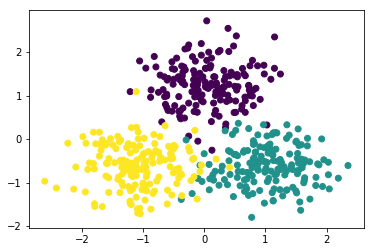

In [5]:
plt.scatter(x[:,0], x[:,1], c=cl)

4. Fit your network using Gradient Descent. Keep track of the total Loss at each iteration and plot the result.

In [6]:
# Random starting points
np.random.seed(45644)
starting_point = np.random.uniform(-.1,.1,size=26).astype("float128")

In [7]:
def grad_descent(x, y,  iterations=10, learning_rate=1e-2):
    point = starting_point
    trajectory = [point]
    losses = [loss(y, yhat(x, y, point))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point - learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, yhat(x, y, point)))
    return (np.array(trajectory), losses)

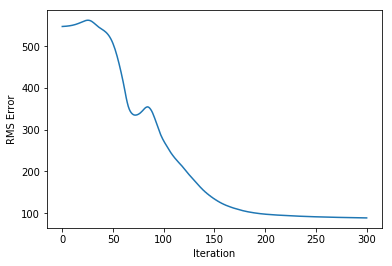

In [8]:
traj, losses = grad_descent(x, y, iterations=300, learning_rate=1e-3)
plt.plot(losses)
plt.ylabel("RMS Error")
plt.xlabel("Iteration")

5. Repeat the exercise above using Momentum. Comment on whether your algorithm seems to converge more efficiently.

In [9]:
def grad_descent_with_momentum(x, y, starting_point=None, iterations=10, alpha=.9, epsilon=0.001):
    point = starting_point
    trajectory = [point]
    losses = [loss(y, yhat(x, y, point))]
    v = np.zeros(point.size)

    for i in range(iterations):
        grad = grad_f(point, x, y)
        v = alpha*v + epsilon*grad
        point = point - v
        trajectory.append(point)
        losses.append(loss(y, yhat(x, y, point)))
        
    return (np.array(trajectory), losses)

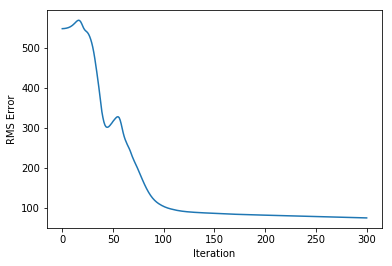

In [10]:
plt.clf()
traj, losses = grad_descent_with_momentum(x, y, starting_point=starting_point, alpha=.5, iterations=300, epsilon=1e-3)
plt.plot(losses)
plt.ylabel("RMS Error")
plt.xlabel("Iteration")

# The gradient descent with momentum seems to converge more efficiently than the one without momentum.

In the last two plots, they clearly show that within first 100 iterations, the method with momentum made error going down to around 100 while the one without momentum made the error decrease to around 300.

For the gradient descent without momentum, it used around 200 iterations to make the error decreased to around 100.

Therefore, the gradient descent method with momentum converge faster (use less iterations to converge).